In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install -qq diffusers datasets accelerate wandb open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... 

In [ ]:
def show_images(dataset, num_samples=20, cols = 3):
  plt.figure(figsize=(15,15))
  for i, img in enumerate(data):
    if i == num_samples:
      break
    plt.subplot(int(num_samples/cols+1), cols, i+1)
    plt.imshow(img['image'])


In [ ]:
from datasets import load_dataset, Image, Dataset

data = load_dataset("nelorth/oxford-flowers", split="train")
data

Dataset({
    features: ['image', 'label'],
    num_rows: 7169
})

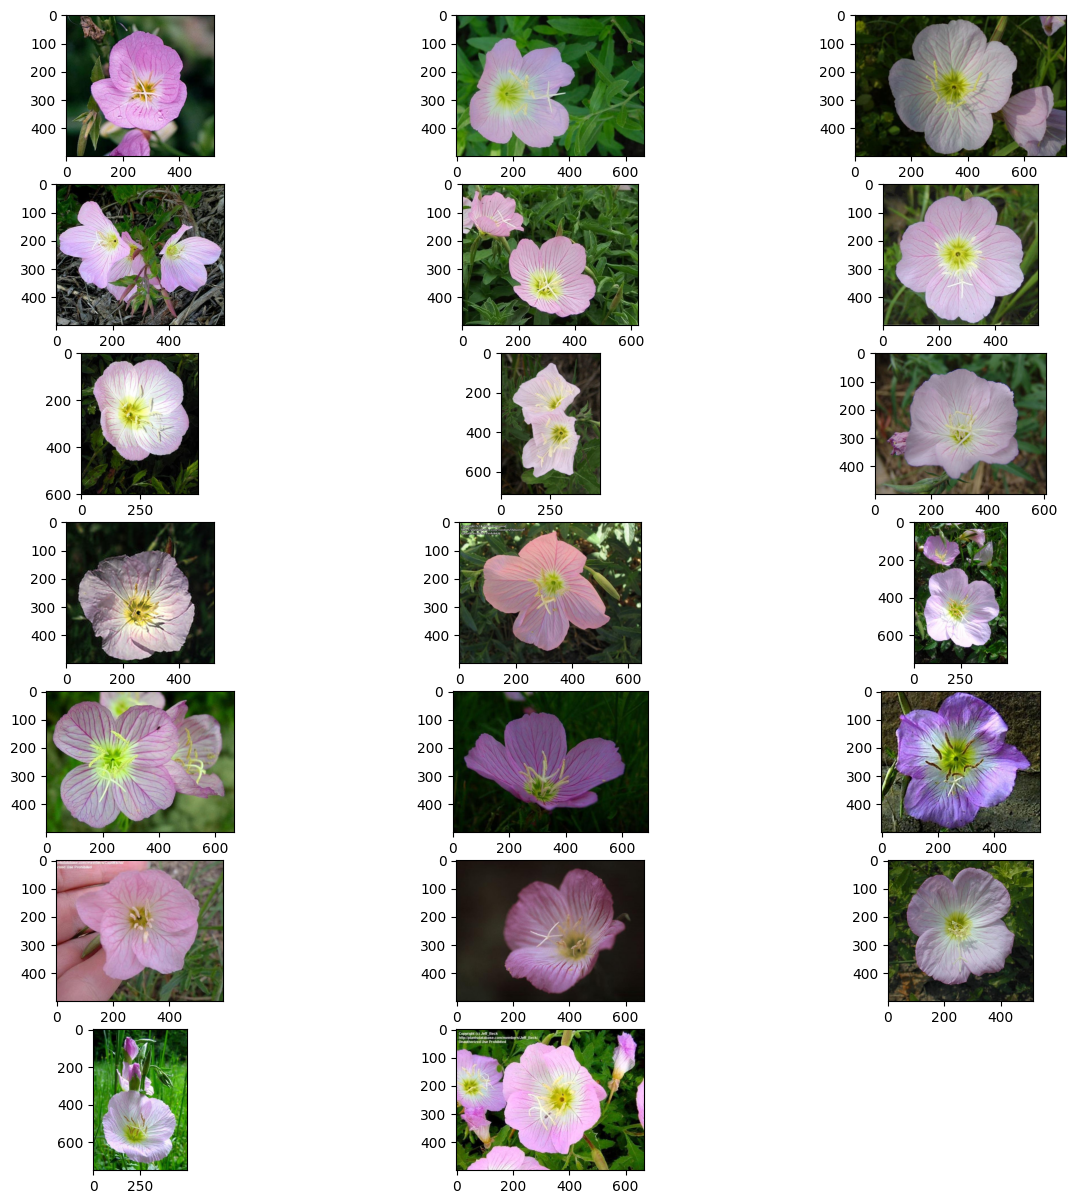

In [ ]:
show_images(data)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchvision.transforms import Compose, ToTensor, CenterCrop, Resize

img_size = 256
transform = Compose([
        Resize(img_size),
        CenterCrop(img_size),
        ToTensor(),
])

In [ ]:
data_tensor = transform(data[0]["image"]).unsqueeze_(0).to(device)

for i in range(1, 7169):
  x = transform(data[i]["image"]).unsqueeze_(0).to(device)
  data_tensor = torch.cat((data_tensor, x))

data_tensor.shape